In [28]:
from pyspark.sql import SparkSession
import re
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline




In [2]:
spark = SparkSession.builder.getOrCreate()
sc = sc = spark.sparkContext

apache_logs = sc.textFile("apache_logs")


In [100]:


def search_result(line):
    regular_expression = r"(?i)\b((?:https?:\/\/|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}\/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))"
    url =re.search(regular_expression, line)
    if url:
        url = url.group(0)
        url = url.replace('//www.','//')
        regular_expression1 = '(?<=\/\/)[^\.]+\.\w+'
        result = re.search(regular_expression1, url)
        if result:
            result = result.group(0)
            return result




lines =apache_logs.map(search_result) 
lines = lines.filter(lambda x: x is not None)
lines = lines.filter(lambda x: x !='semicomplete.com')
lines = lines.map(lambda x: (x,1))
lines = lines.reduceByKey(lambda a, b: a + b)
lines = lines.takeOrdered(10, lambda pair: -pair[1])
lines = pd.DataFrame(lines)
lines


,0,1
0,google.com,909
1,feedparser.org,364
2,search.msn,118
3,FeedBurner.com,108
4,help.yahoo,106
5,yandex.com,86
6,baidu.com,85
7,tt-rss.org,83
8,google.co,77
9,bing.com,63


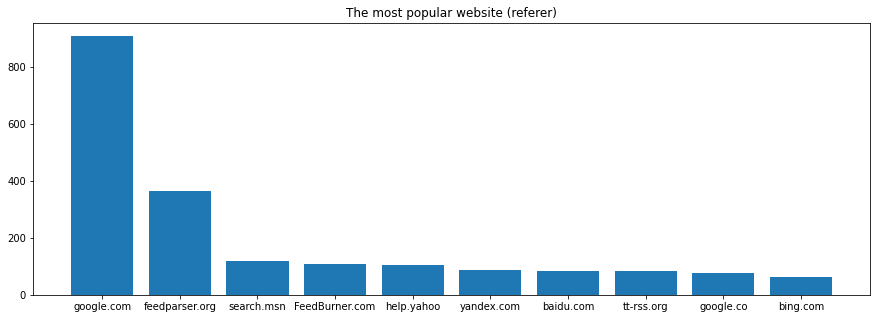

In [104]:
fig = plt.figure(figsize=(15,5))
plt.bar(lines[0],lines[1])
plt.title('The most popular website (referer)')
plt.show()

In [28]:
#\] "(?!GET|HEAD|POST|OPTIONS)

def process(line):
    hour_regex = r"\d{4}:(\d{2}):\d{2}:\d{2}"
    response_regex =r"\"(?:GET|HEAD|POST|OPTIONS)\s[^\"]+\"\s(\d+)"
    hour = int(re.search(hour_regex, line).group(1))
    response = int(re.search(response_regex, line).group(1))
    return ((response, hour),1)
    

    
data = (apache_logs.map(process)
    .reduceByKey(lambda a,b: a+b)
    .sortByKey(ascending=False,keyfunc= lambda x: x)
    .map(lambda x: (x[0][0],x[0][1],x[1]))
    .collect()
)


df = pd.DataFrame(data,columns=['response','hour','amount'])

df


,response,hour,amount
0,500,15,1
1,500,14,1
2,500,3,1
3,416,6,2
4,404,23,4
...,...,...,...
101,200,4,331
102,200,3,338
103,200,2,347
104,200,1,313


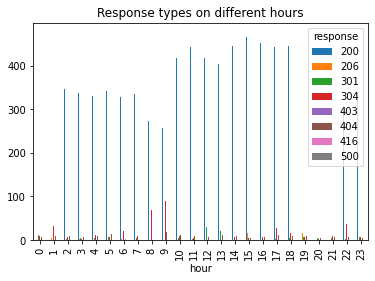

In [29]:
df.pivot("hour", "response", "amount").plot(kind='bar',title='Response types on different hours')
plt.show()


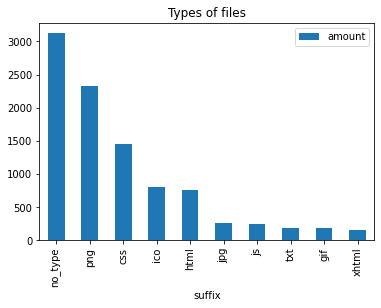

In [36]:

def process(line):
    suffix_regex = r"\"(?:GET|HEAD|POST|OPTIONS)\s[^\"\s]+\.(\w+)(?=\s)"
    ext = re.search(suffix_regex, line)
    if(ext):
        return ext.group(1)

data = (apache_logs.map(process)
    .map(lambda x: 'no_type' if (x is None) else x)
    .map(lambda x: (x,1))
    .reduceByKey(lambda a, b: a + b)
    .takeOrdered(10, lambda pair: -pair[1])
)


df = pd.DataFrame(data,columns=['suffix','amount'])

df.plot(x='suffix',y='amount',kind='bar',title='Types of files')
plt.show()


In [36]:
import ipinfo, pprint
access_token = '487563ad589354'
handler = ipinfo.getHandler(access_token)

regex = '([(\d\.)]+)'
ips = apache_logs.map(lambda s: (re.match(regex, s).group(0)))

results = pprint.pprint(handler.getMap(ips.collect()))



'https://ipinfo.io/tools/map/85802cb8-eccc-4c27-91cf-8af97cf73ca2'


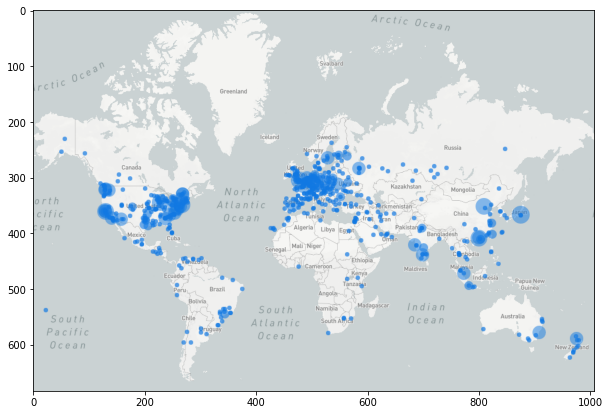

In [42]:
import matplotlib.image as mpimg
img = mpimg.imread('map.png')
plt.figure(figsize=(14,7))
plt.imshow(img)


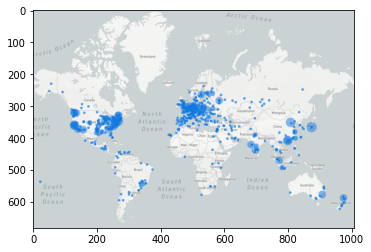

In [40]:
from PIL import Image
img = Image.open('map.png')
  
# Output Images
img.show()

from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image

%matplotlib inline
pil_im = Image.open('map.png', 'r')
imshow(np.asarray(pil_im))



In [133]:
a =[1,2,3,None]
list(map(lambda x: 'no_type' if (x is None) else x,a))




[1, 2, 3, 'no_type']

In [11]:
import folium
m2 = folium.Map(location = [20, 0], tiles = "Mapbox Bright", zoom_start = 2)
marker_cluster = MarkerCluster().add_to(m2)

for i in range(0, len(ip_location_noNan)):
    folium.CircleMarker(location = [ip_location_noNan.iloc[i]['lat'], ip_location_noNan.iloc[i]['lon']], 
                        radius = 5, fill_opacity = 0.9).add_to(marker_cluster)
m2.save('ip_location2.html')



<class 'ValueError'>: Built-in templates for Mapbox and Cloudmade have been removed. You can still use these providers by passing a URL to the `tiles` argument. See the documentation of the `TileLayer` class.

In [27]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
# setup Lambert Conformal basemap.
# set resolution=None to skip processing of boundary datasets.
m = Basemap(width=12000000,height=9000000,projection='lcc',
            resolution=None,lat_1=45.,lat_2=55,lat_0=50,lon_0=-107.)
m.shadedrelief()
plt.show()


<class 'ImportError'>: cannot import name 'dedent' from 'matplotlib.cbook' (/home/x/anaconda3/envs/ml/lib/python3.8/site-packages/matplotlib/cbook/__init__.py)

In [25]:
from  mpl_toolkits.basemap import Basemap


<class 'ModuleNotFoundError'>: No module named 'mpl_toolkits.basemap'